In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers

import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load
from keras.models import load_model
import seaborn as sb
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

# comment the below line if you not using jupyter notebook
%matplotlib inline

In [3]:
print("Started reading the data for training...")
df_ = pd.read_csv('train-NA-removed.csv')
df = df_.copy()
# df_training = df.iloc[:,:].copy()
print("Finished reading the data")

Started reading the data for training...
Finished reading the data


In [4]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,10-07-2016 00:00,21-09-2016 16:25,2,Brown Tabby,0.80,7.78,13,9,0,1
1,ANSL_66892,21-11-2013 00:00,27-12-2018 17:47,1,White,0.72,14.19,13,9,0,2
2,ANSL_71623,31-12-2016 00:00,25-01-2019 18:30,1,White,0.62,17.82,0,1,0,2
3,ANSL_57969,28-09-2017 00:00,19-11-2017 09:38,2,Black,0.50,11.06,18,4,0,1
4,ANSL_52200,25-10-2017 00:00,10-03-2019 13:18,0,Red,0.92,29.56,0,7,1,2


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['color_type'])
df['color_type'] = le.transform(df['color_type'])

In [6]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,10-07-2016 00:00,21-09-2016 16:25,2,18,0.80,7.78,13,9,0,1
1,ANSL_66892,21-11-2013 00:00,27-12-2018 17:47,1,52,0.72,14.19,13,9,0,2
2,ANSL_71623,31-12-2016 00:00,25-01-2019 18:30,1,52,0.62,17.82,0,1,0,2
3,ANSL_57969,28-09-2017 00:00,19-11-2017 09:38,2,2,0.50,11.06,18,4,0,1
4,ANSL_52200,25-10-2017 00:00,10-03-2019 13:18,0,39,0.92,29.56,0,7,1,2


In [23]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['breed_category']])
y = enc.transform(df[['breed_category']]).toarray()

In [8]:
x = df[['condition', 'color_type', 'length(m)', 'height(cm)', 'X1', 'X2']].values

In [9]:
def scaleData(x, y):
    sc_x = StandardScaler()
    sc_y = StandardScaler()

    sc_x.fit(x)
    sc_y.fit(y)
    
    return sc_x, sc_y

In [10]:
sc_x, sc_y = scaleData(x,y)

In [11]:
x_scaled = sc_x.transform(x)

In [24]:
x_train = x_scaled[:15000,:]
y_train = y[:15000,:]
x_val = x_scaled[15000:,:]
y_val = y[15000:,:]

In [38]:
model = Sequential()
Kreg = None

model.add(Dense(64, activation = 'relu', input_shape = (x_train.shape[1],),
                kernel_initializer = glorot_uniform(seed = 1), kernel_regularizer = Kreg))

model.add(Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 2), kernel_regularizer = Kreg))

model.add(Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 3), kernel_regularizer = Kreg))

model.add(Dense(2, activation = 'sigmoid',
                kernel_initializer = glorot_uniform(seed = 4), kernel_regularizer = Kreg))

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 8,898
Trainable params: 8,898
Non-trainable params: 0
_________________________________________________________________


In [61]:
adam = Adam(learning_rate = 0.00003)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['categorical_accuracy'])

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model_cond-4-64.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)
callbacks = [es, mc]

history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_val,y_val),
                    verbose = 1, callbacks = callbacks)

Epoch 1/100
467/469 [============================>.] - ETA: 0s - loss: 0.1617 - categorical_accuracy: 0.8998
Epoch 00001: loss improved from inf to 0.16179, saving model to model_cond-4-64.h5
469/469 [==============================] - 1s 2ms/step - loss: 0.1618 - categorical_accuracy: 0.8997 - val_loss: 0.1834 - val_categorical_accuracy: 0.8757
Epoch 2/100
442/469 [===========================>..] - ETA: 0s - loss: 0.1622 - categorical_accuracy: 0.8995
Epoch 00002: loss did not improve from 0.16179
469/469 [==============================] - 1s 2ms/step - loss: 0.1618 - categorical_accuracy: 0.8996 - val_loss: 0.1837 - val_categorical_accuracy: 0.8761
Epoch 3/100
444/469 [===========================>..] - ETA: 0s - loss: 0.1629 - categorical_accuracy: 0.8982
Epoch 00003: loss improved from 0.16179 to 0.16176, saving model to model_cond-4-64.h5
469/469 [==============================] - 1s 2ms/step - loss: 0.1618 - categorical_accuracy: 0.8995 - val_loss: 0.1836 - val_categorical_accuracy

Epoch 26/100
457/469 [============================>.] - ETA: 0s - loss: 0.1604 - categorical_accuracy: 0.9017
Epoch 00026: loss improved from 0.16118 to 0.16114, saving model to model_cond-4-64.h5
469/469 [==============================] - 1s 2ms/step - loss: 0.1611 - categorical_accuracy: 0.9010 - val_loss: 0.1832 - val_categorical_accuracy: 0.8787
Epoch 27/100
456/469 [============================>.] - ETA: 0s - loss: 0.1613 - categorical_accuracy: 0.9008
Epoch 00027: loss did not improve from 0.16114
469/469 [==============================] - 1s 2ms/step - loss: 0.1612 - categorical_accuracy: 0.9009 - val_loss: 0.1836 - val_categorical_accuracy: 0.8761
Epoch 28/100
450/469 [===========================>..] - ETA: 0s - loss: 0.1616 - categorical_accuracy: 0.9015
Epoch 00028: loss did not improve from 0.16114
469/469 [==============================] - 1s 2ms/step - loss: 0.1611 - categorical_accuracy: 0.9017 - val_loss: 0.1834 - val_categorical_accuracy: 0.8774
Epoch 29/100
467/469 [==

431/469 [==========================>...] - ETA: 0s - loss: 0.1614 - categorical_accuracy: 0.9017
Epoch 00050: loss did not improve from 0.16055
469/469 [==============================] - 1s 2ms/step - loss: 0.1606 - categorical_accuracy: 0.9031 - val_loss: 0.1843 - val_categorical_accuracy: 0.8791
Epoch 51/100
464/469 [============================>.] - ETA: 0s - loss: 0.1606 - categorical_accuracy: 0.9013
Epoch 00051: loss did not improve from 0.16055
469/469 [==============================] - 1s 3ms/step - loss: 0.1606 - categorical_accuracy: 0.9011 - val_loss: 0.1841 - val_categorical_accuracy: 0.8791
Epoch 52/100
444/469 [===========================>..] - ETA: 0s - loss: 0.1604 - categorical_accuracy: 0.9016
Epoch 00052: loss improved from 0.16055 to 0.16050, saving model to model_cond-4-64.h5
469/469 [==============================] - 1s 3ms/step - loss: 0.1605 - categorical_accuracy: 0.9016 - val_loss: 0.1837 - val_categorical_accuracy: 0.8804
Epoch 53/100
457/469 [===============

454/469 [============================>.] - ETA: 0s - loss: 0.1598 - categorical_accuracy: 0.9020
Epoch 00075: loss did not improve from 0.15996
469/469 [==============================] - 1s 2ms/step - loss: 0.1600 - categorical_accuracy: 0.9019 - val_loss: 0.1837 - val_categorical_accuracy: 0.8791
Epoch 76/100
448/469 [===========================>..] - ETA: 0s - loss: 0.1600 - categorical_accuracy: 0.9033
Epoch 00076: loss improved from 0.15996 to 0.15984, saving model to model_cond-4-64.h5
469/469 [==============================] - 1s 2ms/step - loss: 0.1598 - categorical_accuracy: 0.9031 - val_loss: 0.1837 - val_categorical_accuracy: 0.8765
Epoch 77/100
462/469 [============================>.] - ETA: 0s - loss: 0.1600 - categorical_accuracy: 0.9031
Epoch 00077: loss did not improve from 0.15984
469/469 [==============================] - 1s 2ms/step - loss: 0.1599 - categorical_accuracy: 0.9029 - val_loss: 0.1839 - val_categorical_accuracy: 0.8782
Epoch 78/100
442/469 [===============

451/469 [===========================>..] - ETA: 0s - loss: 0.1594 - categorical_accuracy: 0.9038
Epoch 00100: loss did not improve from 0.15932
469/469 [==============================] - 1s 2ms/step - loss: 0.1594 - categorical_accuracy: 0.9038 - val_loss: 0.1841 - val_categorical_accuracy: 0.8774


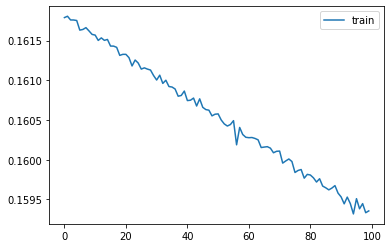

In [62]:
plt.figure()
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

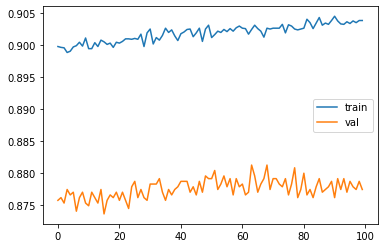

In [63]:
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [64]:
ymodel = model.predict(x_val)

In [65]:
ymodel = enc.inverse_transform(ymodel)
y_act = enc.inverse_transform(y_val)

In [66]:
from sklearn.metrics import f1_score

In [67]:
f1_score(ymodel[:,0],y_act[:,0],average='weighted')

0.8773846962702331